# Calculating Lyapunov Exponents with [ForwardDiff.jl] and [DifferentialEquations.jl]

Julia has a [rich stack of auto-differentiation tools](https://github.com/JuliaDiff), including [ForwardDiff.jl].  I just noticed calculating Lyapunov exponents using [ForwardDiff.jl] and [DifferentialEquations.jl] is quite easy.  Basically, you calculate the derivative of the phase space dynamics at the same time for the tangent space derivative (see `tangent_dynamics` function) using `ForwardDiff.jacobian!` and pass that to `DifferentialEquations` solver.  Thanks to [ForwardDiff.jl], this calculation can be done automagically for *any* dynamical system defined on real Euclidean space; i.e., the function `phase_dynamics(t, u, du)` defining phase space dynamics can accept any type of `Array{Real}` for `u` and `du`.  This means that the function `phase_dynamics` can contain arbitrary Julia code such as "if" statement as in `piecewise_linear` example below.

[ForwardDiff.jl]: https://github.com/JuliaDiff/ForwardDiff.jl
[DifferentialEquations.jl]: https://github.com/JuliaDiffEq/DifferentialEquations.jl

In [1]:
using DifferentialEquations

In [2]:
using Plots

In [3]:
include("LyapunovExponentsWithForwardDiff.jl")
lyapunov_exponents = LyapunovExponentsWithForwardDiff.lyapunov_exponents

lyapunov_exponents (generic function with 1 method)

In [4]:
?lyapunov_exponents

search:



`lyapunov_exponents(phase_dynamics, u0, t_chunk, num_tran, num_attr; ...)`

### Positional Arguments

  * `phase_dynamics`: Definition of the phase space dynamics in the inplace `(t, u, du)` format (as in `ODEProblem`).
  * `u0`: Initial state for the phase space dynamics.
  * `t_chunk`: Length of numerical integration between orthonormalization.
  * `num_tran`: Number of iterations to through away to get rid of the transient dynamics.
  * `num_attr`: Number of orthonormalization steps for Lyapunov exponent calculation (which is presumably done inside an attractor).

### Keyword Arguments

  * `dim_lyap`: Number of Lyapunov exponents to be calculated. Default to the full system dimension.
  * `Q0`: The initial guess of the Gram-Schmidt "Lyapunov vectors". Default to the identity matrix.


# Examples

## Lorenz system

* https://en.wikipedia.org/wiki/Lorenz_system
* http://sprott.physics.wisc.edu/chaos/comchaos.htm
* E. N. Lorenz, J. Atmos. Sci. 20, 130-141 (1963)

In [5]:
lorenz = @ode_def Lorenz begin
  dx = σ*(y-x)
  dy = ρ*x-y-x*z
  dz = x*y-β*z
end σ = 10. β = 8.0/3.0 ρ => 28.

(::Lorenz) (generic function with 12 methods)

In [6]:
u0 = [-11.8, -5.1, 37.5]
tspan = (0., 30.)
prob = ODEProblem(lorenz, u0, tspan)
sol = solve(prob,Vern7(),reltol=1e-12,abstol=1e-12);


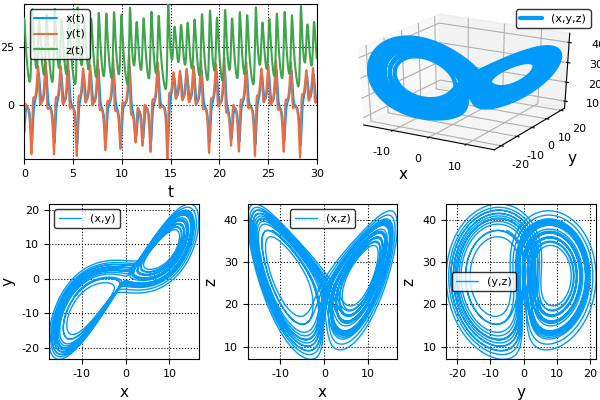

In [7]:
#plot(sol, vars=(1,2,3), linewidth=0.5, label="")
xyzt = plot(sol, plotdensity=10000,lw=1.5)
xy = plot(sol, plotdensity=10000, vars=(:x,:y))
xz = plot(sol, plotdensity=10000, vars=(:x,:z))
yz = plot(sol, plotdensity=10000, vars=(:y,:z))
xyz = plot(sol, plotdensity=10000, vars=(:x,:y,:z))
plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), layout=(2,1))

#### Lyapunov exponents of the Lorenz system

In [ ]:
res = lyapunov_exponents(lorenz, u0, 1.0, 10, 1000)

plot(res; known=[0.901658, 0.0014, -14.5558])

### Simplest piecewise linear dissipative chaotic flow (Linz and Sprott, 1999)

* http://sprott.physics.wisc.edu/chaos/comchaos.htm
* S. J. Linz and J. C. Sprott, Phys. Lett. A 259, 240-245 (1999)

In [ ]:
function piecewise_linear(t, u, du)
    du[1] = u[2]
    du[2] = u[3]
    du[3] = -0.6 * u[3] - u[2] - (u[1] > 0 ? u[1] : -u[1]) + 1
end

In [ ]:
sol = solve(ODEProblem(piecewise_linear, [0.1, 0.1, 0.1], (0.0, 100.0)));

In [ ]:
plot(sol, vars=(1,2,3), linewidth=0.5, label="")

#### Lyapunov exponents of the piecewise linear system

In [ ]:
res = lyapunov_exponents(piecewise_linear, [0.1, 0.1, 0.1], 1.0, 10, 10000)

In [ ]:
plot(res; known=[0.0362, 0, -0.6362])

### Small recurrent neural network (Beer, 1995)

* Beer, R. D. (1995). On the dynamics of small continuous-time recurrent neural networks. Adapt. Behav., 3(4), 469–509. http://doi.org/10.1177/105971239500300405

In [ ]:
module RNN

using DifferentialEquations
using ParameterizedFunctions

type RNNParam
    w
    θ
    τ
end

σ(x) = 1 / (1 + exp(-x))

function rnn(t, u, param, du)
    w = param.w
    θ = param.θ
    τ = param.τ
    du .= (- u .+ w * σ.(u .+ θ)) ./ τ
end

function beer1995()
    ParameterizedFunction(rnn, RNNParam(
        # w
        [  5.422  -0.018  2.75
          -0.24    4.59   1.21
           0.535  -2.25   3.885 ],
        # θ
        [-4.108, -2.787, -1.114],
        # τ
        [1.0, 2.5, 1.0],
    ))
end

end

In [ ]:
beer1995 = RNN.beer1995()

In [ ]:
sol = solve(ODEProblem(beer1995, ones(3), (0.0, 1000.0)));

In [ ]:
plot(sol, vars=(1,2,3), linewidth=0.5, label="")

#### Lyapunov exponents of the RNN

In [ ]:
res = lyapunov_exponents(beer1995, ones(3), 1.0, 10, 10000)

In [ ]:
plot(res; known=[0.01, 0, NaN])